# Graph Construction With All Featues (Target Column: Sensory)

In [1]:
!pip install torch
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-1.9.0+cu111.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=3764962 sha256=955fa16eefbd8069ad9e6d185cee235456be6464e57b2ef65f20d8096ef8a170
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-1.9.0+cu111.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=2625879 sha256=6237f2476538e0922b6380e9928baa09ea625c5893ca075f7e9ac50d72ad57e8
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully b

In [2]:
import torch
import pandas as pd
import numpy as np


file_path = "/kaggle/input/all-based-sensory-data/All-based-Sensory.csv"
data = pd.read_csv(file_path)


target_column = 'Sensory'


non_numeric_columns = ['Image']  
data = data.drop(columns=non_numeric_columns)




print(data.describe())
print(data.isin([np.inf, -np.inf]).sum())


data.replace([np.inf, -np.inf], np.nan, inplace=True)


data.dropna(inplace=True)


data.fillna(data.mean(), inplace=True)


print(data.isna().sum())
print(data.describe())
print(data.isin([np.inf, -np.inf]).sum())


X = data.drop(columns=[target_column])
y = data[target_column]

             Area    PA_ratio    Solidity  Circularity  EquivDiameter  \
count  450.000000  450.000000  450.000000   450.000000     450.000000   
mean    12.331111    0.669406    0.803765          inf       3.369617   
std     19.569172    0.390348    0.206400          NaN       2.087060   
min      1.000000    0.000000    0.239752     0.089574       1.128379   
25%      3.000000    0.333333    0.655982     1.075594       1.954410   
50%      6.000000    0.819516    0.833333     2.317325       2.763953   
75%     14.750000    0.960925    1.000000    37.699112       4.333147   
max    228.000000    1.167658    1.000000          inf      17.038152   

       ConvexArea      Extent  FilledArea  Major axis length  \
count  450.000000  450.000000  450.000000         450.000000   
mean    22.893333    0.637418   12.466667           5.955634   
std     56.968535    0.257433   20.230630           5.475747   
min      1.000000    0.134115    1.000000           0.000000   
25%      3.000000    0

/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


# Graph Convolutional Network (GCN)

In [3]:
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


target_column = 'Sensory'

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

num_nodes = X_train_tensor.shape[0]
edge_index = torch.combinations(torch.arange(num_nodes), r=2).t()

data = Data(x=X_train_tensor, edge_index=edge_index, y=y_train_tensor)

num_train = int(0.8 * num_nodes)
num_val = int(0.1 * num_nodes)
num_test = num_nodes - num_train - num_val

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[:num_train] = True
val_mask[num_train:num_train + num_val] = True
test_mask[num_train + num_val:] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(in_channels=X_train_tensor.shape[1], out_channels=2) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits, accs = model(data), []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

loss_values = []
train_acc_values = []
val_acc_values = []
test_acc_values = []

for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    loss_values.append(loss)
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)
    test_acc_values.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch: 001, Loss: 0.8582, Train Acc: 0.4758, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 002, Loss: 0.7168, Train Acc: 0.5198, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 003, Loss: 0.6930, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 004, Loss: 0.6959, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 005, Loss: 0.7089, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 006, Loss: 0.7359, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 007, Loss: 0.7151, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 008, Loss: 0.7102, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 009, Loss: 0.7118, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 010, Loss: 0.6963, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 011, Loss: 0.6947, Train Acc: 0.5286, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 012, Loss: 0.6915, Train Acc: 0.5286, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 013, Loss: 0.6904, Train Acc: 0.5330, Val Acc

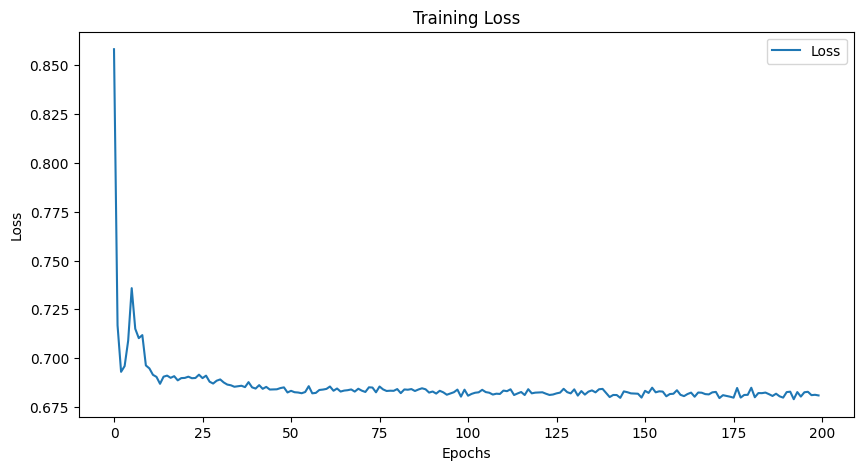

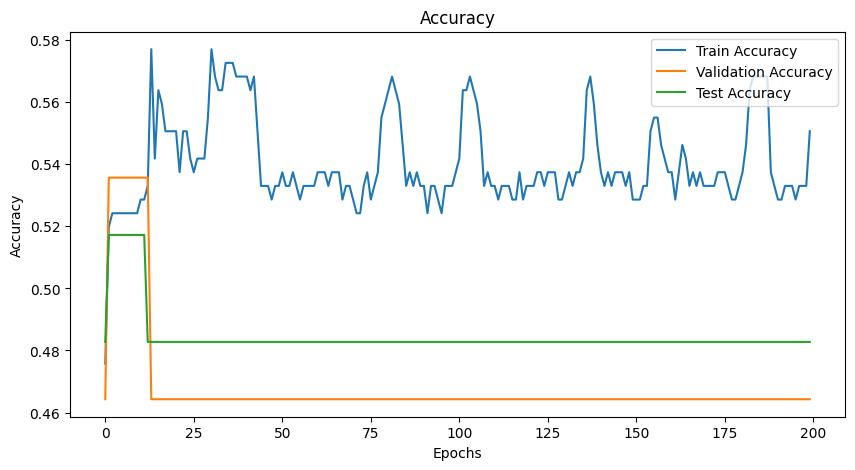

In [4]:
import torch
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.plot(test_acc_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


# Graph Attention Network (GAT)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads)
        self.conv2 = GATConv(hidden_channels * num_heads, out_channels, heads=num_heads)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GAT(in_channels=X_train_tensor.shape[1], hidden_channels=8, out_channels=2, num_heads=8) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits, accs = model(data), []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

loss_values = []
train_acc_values = []
val_acc_values = []
test_acc_values = []

for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    loss_values.append(loss)
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)
    test_acc_values.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 5.0197, Train Acc: 0.0000, Val Acc: 0.0000, Test Acc: 0.0000
Epoch: 002, Loss: 3.6943, Train Acc: 0.4405, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 003, Loss: 2.4881, Train Acc: 0.5154, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 004, Loss: 2.7839, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 005, Loss: 1.4976, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 006, Loss: 1.4070, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 007, Loss: 1.3915, Train Acc: 0.5286, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 008, Loss: 0.8470, Train Acc: 0.5154, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 009, Loss: 0.9537, Train Acc: 0.5022, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 010, Loss: 0.8042, Train Acc: 0.4758, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 011, Loss: 0.8720, Train Acc: 0.4758, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 012, Loss: 1.0797, Train Acc: 0.5066, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 013, Loss: 1.1883, Train Acc: 0.5330, Val Acc

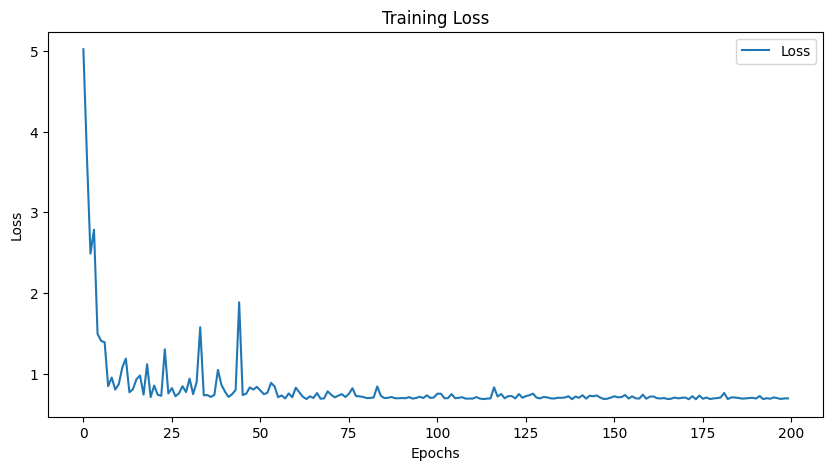

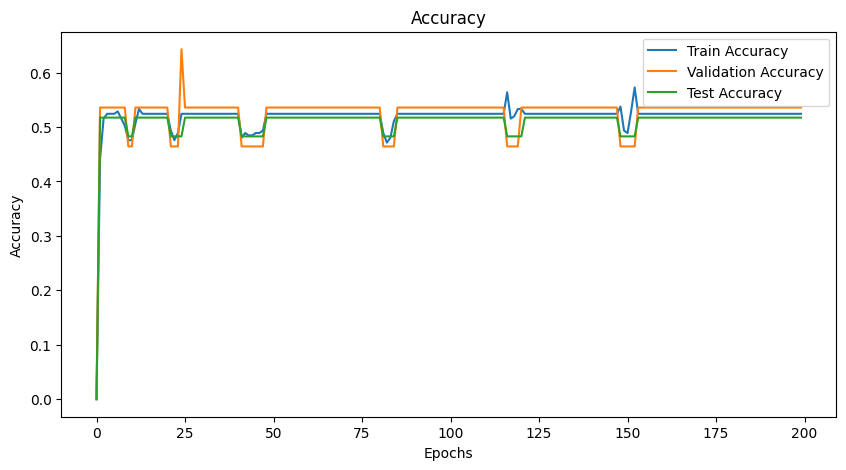

In [6]:
import torch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.plot(test_acc_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


# Graph Sample & Aggregate (GraphSAGE)

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [8]:
import torch
from torch_geometric.data import Data

data = Data(x=X_train_tensor, edge_index=edge_index, y=y_train_tensor)

num_train = int(0.8 * num_nodes)
num_val = int(0.1 * num_nodes)
num_test = num_nodes - num_train - num_val

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[:num_train] = True
val_mask[num_train:num_train + num_val] = True
test_mask[num_train + num_val:] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

import torch.nn.functional as F

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GraphSAGE(in_channels=X_train_tensor.shape[1], hidden_channels=16, out_channels=2)  # Adjust parameters as needed
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits, accs = model(data.x, data.edge_index), []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

loss_values = []
train_acc_values = []
val_acc_values = []
test_acc_values = []

for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    loss_values.append(loss)
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)
    test_acc_values.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Loss: 0.6569, Train Acc: 0.7137, Val Acc: 0.6786, Test Acc: 0.6552
Epoch: 002, Loss: 0.5988, Train Acc: 0.7533, Val Acc: 0.7143, Test Acc: 0.7241
Epoch: 003, Loss: 0.5901, Train Acc: 0.7489, Val Acc: 0.7143, Test Acc: 0.6897
Epoch: 004, Loss: 0.5666, Train Acc: 0.7665, Val Acc: 0.7143, Test Acc: 0.6897
Epoch: 005, Loss: 0.5466, Train Acc: 0.7709, Val Acc: 0.7143, Test Acc: 0.6897
Epoch: 006, Loss: 0.5364, Train Acc: 0.7577, Val Acc: 0.7500, Test Acc: 0.6897
Epoch: 007, Loss: 0.5390, Train Acc: 0.7665, Val Acc: 0.7857, Test Acc: 0.7586
Epoch: 008, Loss: 0.5098, Train Acc: 0.7709, Val Acc: 0.7500, Test Acc: 0.7586
Epoch: 009, Loss: 0.4958, Train Acc: 0.7797, Val Acc: 0.7500, Test Acc: 0.7586
Epoch: 010, Loss: 0.5030, Train Acc: 0.7797, Val Acc: 0.7857, Test Acc: 0.7241
Epoch: 011, Loss: 0.4848, Train Acc: 0.7797, Val Acc: 0.7857, Test Acc: 0.7241
Epoch: 012, Loss: 0.5030, Train Acc: 0.7885, Val Acc: 0.7500, Test Acc: 0.7931
Epoch: 013, Loss: 0.4627, Train Acc: 0.7930, Val Acc

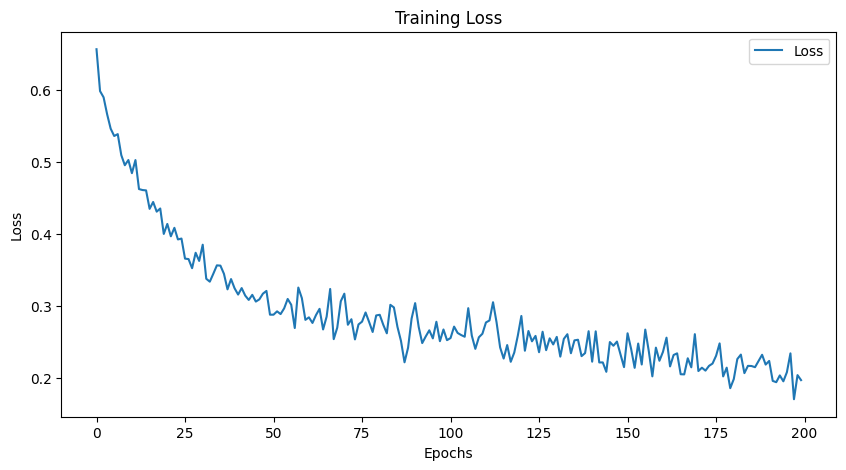

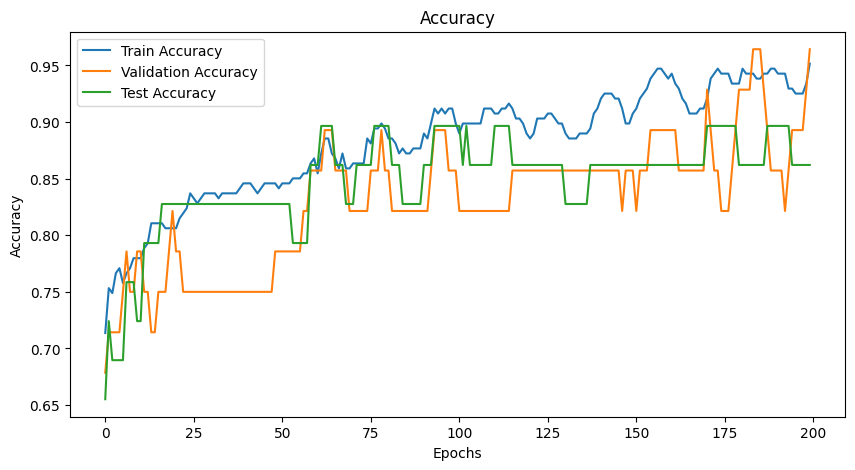

In [9]:
import torch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.plot(test_acc_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


# Variational Graph Autoencoder (VGAE)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class VGAEEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(VGAEEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class VGAE(torch.nn.Module):
    def __init__(self, encoder):
        super(VGAE, self).__init__()
        self.encoder = encoder

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        mu = z
        logvar = z
        z = self.reparameterize(mu, logvar)
        return F.log_softmax(z, dim=1), mu, logvar


In [11]:
import torch

encoder = VGAEEncoder(in_channels=X_train_tensor.shape[1], hidden_channels=16, out_channels=2)
model = VGAE(encoder)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out, mu, logvar = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss += kl_loss
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits, _, _ = model(data.x, data.edge_index)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs
loss_values = []
train_acc_values = []
val_acc_values = []
test_acc_values = []

for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    loss_values.append(loss)
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)
    test_acc_values.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 41.4071, Train Acc: 0.5595, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 002, Loss: 35.0879, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 003, Loss: 10.3608, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 004, Loss: 35.7265, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 005, Loss: 3.8619, Train Acc: 0.5330, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 006, Loss: 51.7602, Train Acc: 0.4802, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 007, Loss: 21.5294, Train Acc: 0.4758, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 008, Loss: 23.8483, Train Acc: 0.4758, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 009, Loss: 9.0703, Train Acc: 0.4758, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 010, Loss: 4.8736, Train Acc: 0.4758, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 011, Loss: 10.0376, Train Acc: 0.4758, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 012, Loss: 7.0029, Train Acc: 0.5551, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 013, Loss: 4.1218, Train Acc: 0.5683,

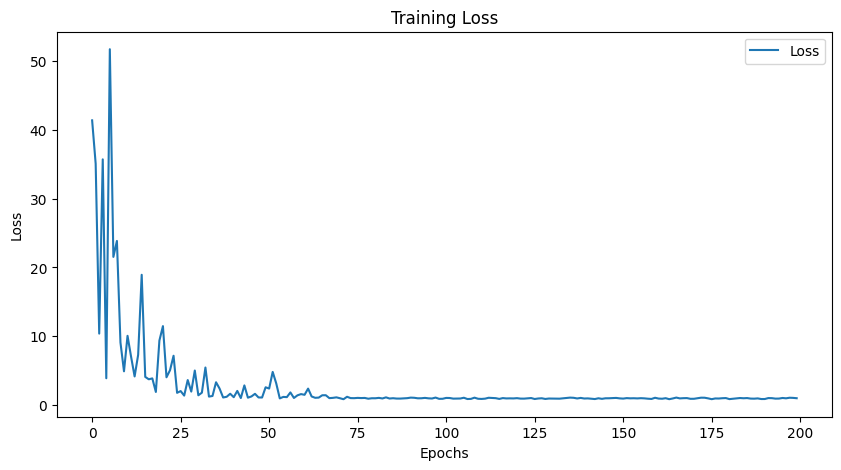

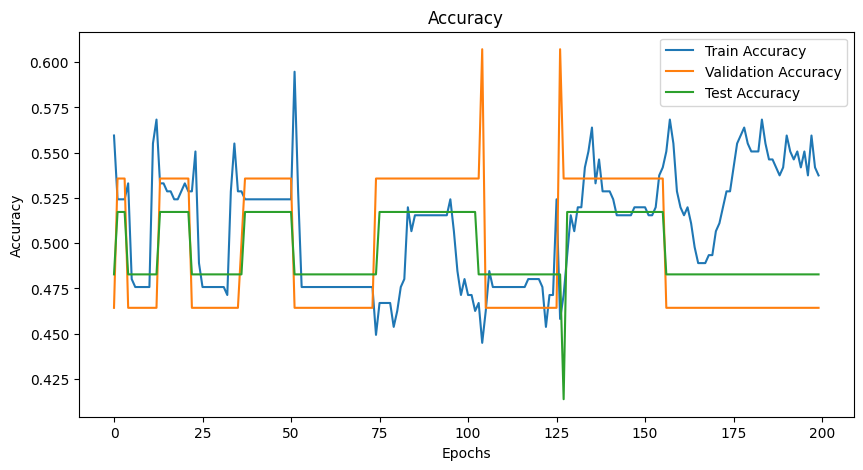

In [12]:
import torch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.plot(test_acc_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


# Deep Graph Infomax (DGI)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class DGI(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(DGI, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)


In [14]:
import torch.nn.functional as F

model = DGI(in_channels=X_train_tensor.shape[1], hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits = model(data.x, data.edge_index)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

loss_values = []
train_acc_values = []
val_acc_values = []
test_acc_values = []

for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    loss_values.append(loss)
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)
    test_acc_values.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Loss: 3.2473, Train Acc: 0.0000, Val Acc: 0.0000, Test Acc: 0.0000
Epoch: 002, Loss: 2.9149, Train Acc: 0.0617, Val Acc: 0.0000, Test Acc: 0.0000
Epoch: 003, Loss: 2.6058, Train Acc: 0.5286, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 004, Loss: 2.3116, Train Acc: 0.5286, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 005, Loss: 2.0313, Train Acc: 0.5286, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 006, Loss: 1.7633, Train Acc: 0.5286, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 007, Loss: 1.5112, Train Acc: 0.5286, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 008, Loss: 1.2946, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 009, Loss: 1.1152, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 010, Loss: 0.9768, Train Acc: 0.5286, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 011, Loss: 0.8776, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 012, Loss: 0.8109, Train Acc: 0.5286, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 013, Loss: 0.7675, Train Acc: 0.5198, Val Acc

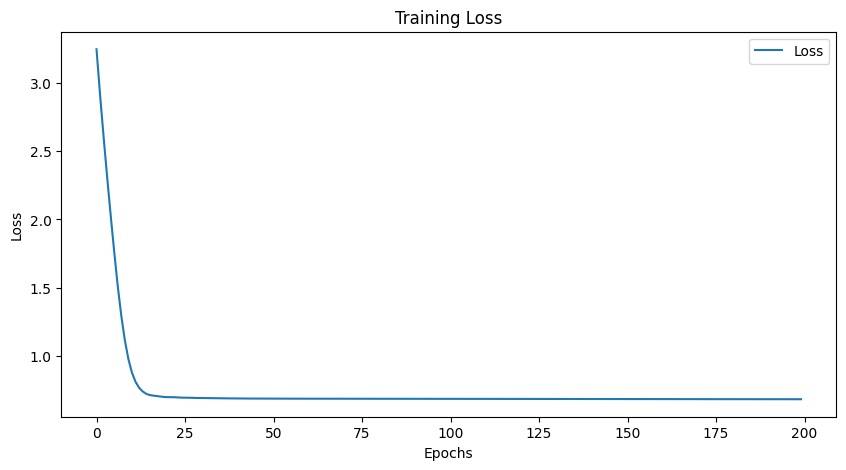

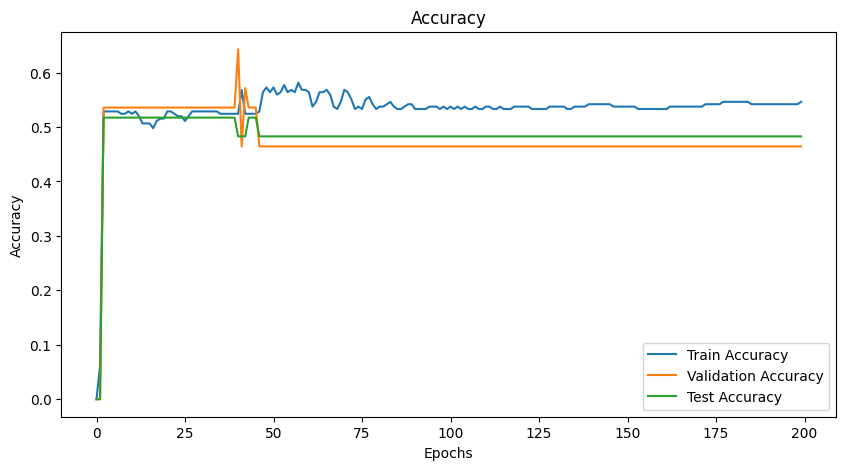

In [15]:
import torch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.plot(test_acc_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# Graph Isomorphism Network (GIN)

In [16]:
from torch_geometric.nn import GINConv, global_add_pool
import torch

class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GIN, self).__init__()
        self.conv1 = GINConv(torch.nn.Linear(in_channels, hidden_channels))
        self.conv2 = GINConv(torch.nn.Linear(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GIN(in_channels=X_train_tensor.shape[1], hidden_channels=16, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits = model(data.x, data.edge_index)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

loss_values = []
train_acc_values = []
val_acc_values = []
test_acc_values = []

for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    loss_values.append(loss)
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)
    test_acc_values.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Loss: 24.5548, Train Acc: 0.4978, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 002, Loss: 52.4949, Train Acc: 0.4978, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 003, Loss: 66.2620, Train Acc: 0.5154, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 004, Loss: 29.0062, Train Acc: 0.5374, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 005, Loss: 10.3056, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 006, Loss: 47.4956, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 007, Loss: 49.4098, Train Acc: 0.5242, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 008, Loss: 41.3737, Train Acc: 0.5286, Val Acc: 0.5357, Test Acc: 0.5172
Epoch: 009, Loss: 21.6917, Train Acc: 0.5022, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 010, Loss: 5.0425, Train Acc: 0.5066, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 011, Loss: 20.2351, Train Acc: 0.5154, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 012, Loss: 22.7160, Train Acc: 0.5110, Val Acc: 0.4643, Test Acc: 0.4828
Epoch: 013, Loss: 33.5277, Train Acc: 0.5

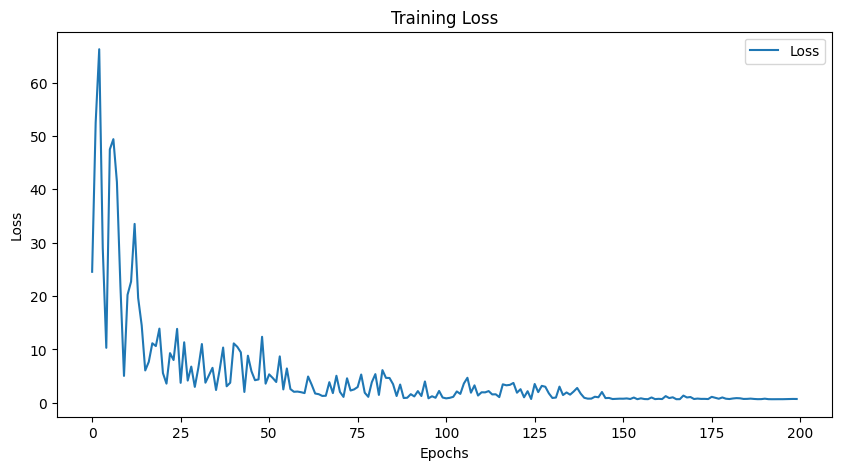

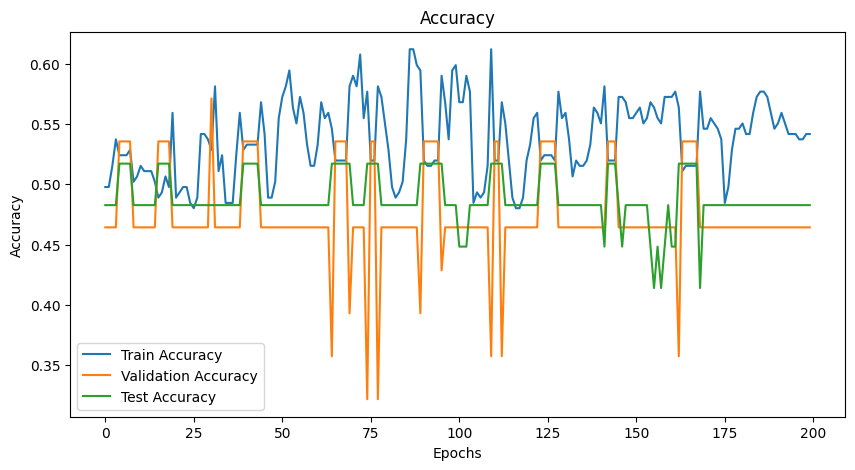

In [17]:
import torch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.plot(test_acc_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()